In [28]:
import pandas as pd
import numpy as np
from scipy import signal, optimize, special
import matplotlib.pyplot as plt
import math
#from typing import Iterable
#from pomocne_funkce.uprava_vystupu import zaokrouhleni # FIXME: tohle odmítá fungovat
from uprava_vystupu import zaokrouhleni

In [39]:
def metoda_ostre_hrany(x, x_0, w, P_0, P_max):
    return P_0+(P_max/2)*(1-special.erf(np.sqrt(2)*(x_0-x)/w))

In [30]:
stored_data = {25:"B, C", 28:"D, E", 30:"F, G", 32:"H, I", 
               34:"J, K", 35:"L, M", 36:"N, O", 38:"P, Q",
               40:"R,S", 42:"T, U", 45:"V, W"}
namerene_hodnoty = dict()
for z, sloupce in stored_data.items():
    data = pd.read_excel("data_07.xlsx", engine="openpyxl", usecols=sloupce, skiprows=2).dropna()
    data.columns=["x[mm]", "U[mV]"]
    namerene_hodnoty.update({z: data})

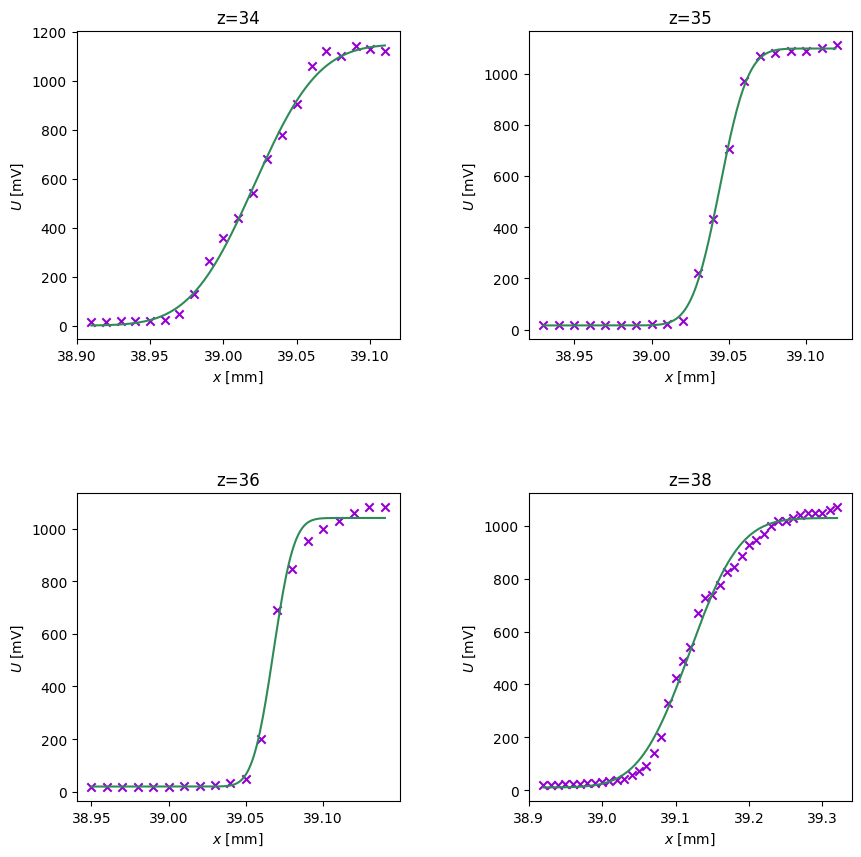

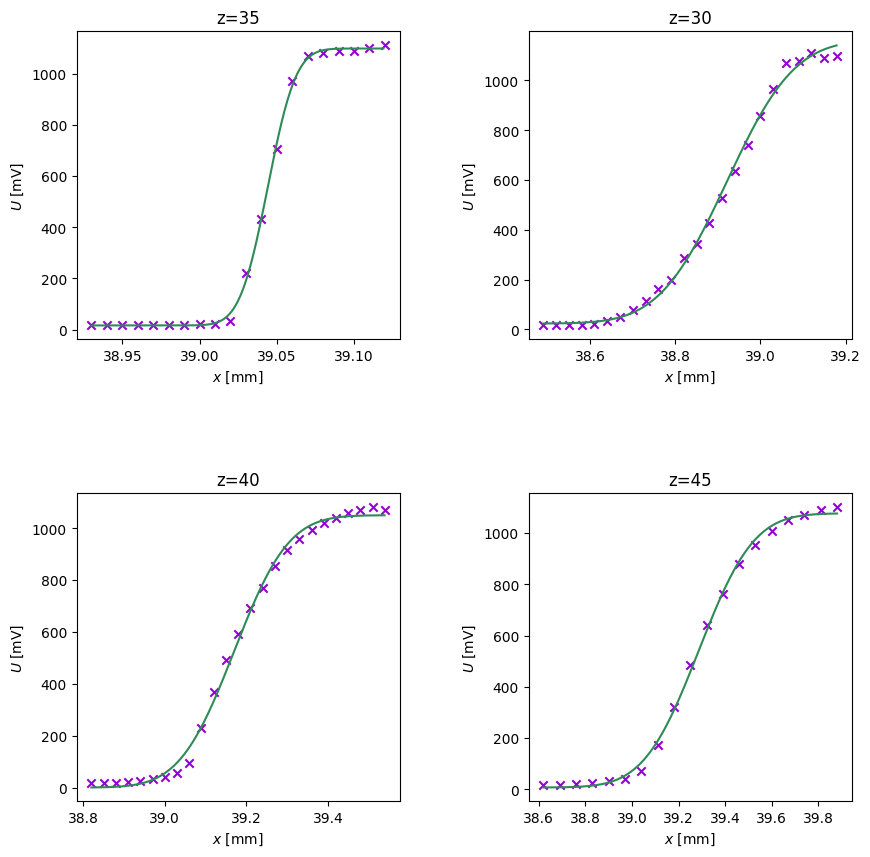

In [ ]:
vysledky_fitu = dict()
for z, data in namerene_hodnoty.items():
    x_0 = np.mean(data["x[mm]"])
    w = 0.5
    P_0 = data["U[mV]"].min()
    P_max = data["U[mV]"].max()

    fitovane_parametry, kovariance_parametru = optimize.curve_fit(metoda_ostre_hrany, 
                                                                      xdata=data["x[mm]"], 
                                                                      ydata=data["U[mV]"],
                                                                      p0=[x_0, w, P_0, P_max])
    sigma_parametru = np.sqrt(np.diag(kovariance_parametru)) # tohle vypocita presnost, s jakou byly parametry urceny
    zaokrouhlene_parametry = []
    for j in range(len(fitovane_parametry)): # zaokrouhleni na jednu platnou cifru
        zaokrouhlene_parametry.append(zaokrouhleni(fitovane_parametry[j], 
                                                         reference=sigma_parametru[j]))
    #print(zaokrouhlene_parametry)
    vysledky_fitu.update({z:{"x_0":zaokrouhlene_parametry[0],
                             "w":zaokrouhlene_parametry[1],
                             "P_0":zaokrouhlene_parametry[2],
                             "P_max":zaokrouhlene_parametry[3]}})
    

#for z, data in namerene_hodnoty.items():
#    parametry = vysledky_fitu[z]
#    x_axis=np.arange(data["x[mm]"].min(), data["x[mm]"].max(), step=0.001)
#    plt.scatter(data["x[mm]"], data["U[mV]"])
#    plt.plot(x_axis, metoda_ostre_hrany(x_axis, parametry["x_0"][0], parametry["w"][0], 
#                                        parametry["P_0"][0], parametry["P_max"][0]))
#    plt.title(f"z={z}")
#    plt.show()

graf1_z = [[34, 35], [36, 38]]
graf2_z = [[35, 30], [40, 45]]

fig1, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for i, row in enumerate(graf1_z):
    for j, z in enumerate(row):
        parametry = vysledky_fitu[z]
        data=namerene_hodnoty[z]
        x_axis=np.arange(data["x[mm]"].min(), data["x[mm]"].max(), step=0.001)
        ax[i,j].scatter(x=data["x[mm]"], y=data["U[mV]"], 
                         color="darkviolet", marker="x")
        ax[i,j].plot(x_axis, metoda_ostre_hrany(x_axis, parametry["x_0"][0], parametry["w"][0], 
                                                 parametry["P_0"][0], parametry["P_max"][0]),
                                            color="seagreen")
        ax[i,j].set_title(f"z={z}")
        ax[i,j].set_xlabel("$x$ [mm]")
        ax[i,j].set_ylabel("$U$ [mV]")

fig1.savefig("./img/graf1.pdf")

fig2, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for i, row in enumerate(graf2_z):
    for j, z in enumerate(row):
        parametry = vysledky_fitu[z]
        data=namerene_hodnoty[z]
        x_axis=np.arange(data["x[mm]"].min(), data["x[mm]"].max(), step=0.001)
        ax[i,j].scatter(x=data["x[mm]"], y=data["U[mV]"], 
                         color="darkviolet", marker="x")
        ax[i,j].plot(x_axis, metoda_ostre_hrany(x_axis, parametry["x_0"][0], parametry["w"][0], 
                                                 parametry["P_0"][0], parametry["P_max"][0]),
                                            color="seagreen")
        ax[i,j].set_title(f"z={z}")
        ax[i,j].set_xlabel("$x$ [mm]")
        ax[i,j].set_ylabel("$U$ [mV]")

fig2.savefig("./img/graf2.pdf")

  

